<div style="width:90%;
            margin:10px;
            padding:8px;
            border:2px solid #FF0000;
            border-radius:20px;
            font-weight:bold;
            font-size:2.5em;
            text-align:center;">
The Double Oscillator Problem
</div>


<div style="width:90%;
            margin:9px;
            font-size:1em;">
            
*The Double Oscillator Problem:* The problem is to find the optimal control for a double oscillator system.                                 
The problem is inspired from : [Optimal bang-bang control of a mechanical double oscillator using averaging methods](https://cas.mines-paristech.fr/~petit/papers/mathmod2018/main.pdf) by Christophe Coudurier, Olivier Lepreux and Nicolas Petit.                        
We solve the problem using the [JuMP](https://jump.dev/) and [OptimalControl](https://control-toolbox.org/OptimalControl.jl/stable/) packages in Julia then we compare the results.

1. [JuMP Formulation](#jump)
2. [OptimalControl Formulation](#oc)
3. [Comparison](#comp)

</div>

In [2]:
import Pkg
Pkg.activate("..")
include("./utils.jl");

  Activating project at `c:\Users\hajje\Dropbox\PC\Desktop\Stage\COTS`


## 1. Solving with JuMP <a id='jump'></a>

In [3]:
using JuMP , Ipopt
import HSL_jll
include("../Problems/JuMP/oscillator_JMP.jl");
nh=500;
OscillatorJMP = double_oscillator_JMP(;N=nh)

set_optimizer(OscillatorJMP,Ipopt.Optimizer)
set_attribute(OscillatorJMP, "print_level", 5)
set_optimizer_attribute(OscillatorJMP,"tol",1e-8)
set_optimizer_attribute(OscillatorJMP,"constr_viol_tol",1e-6)
set_optimizer_attribute(OscillatorJMP,"max_iter",1000)
set_optimizer_attribute(OscillatorJMP,"mu_strategy","adaptive")
set_attribute(OscillatorJMP, "hsllib", HSL_jll.libhsl_path)
set_attribute(OscillatorJMP, "linear_solver", "ma27")

In [4]:
println("Solving...")
optimize!(OscillatorJMP)
println()

# Display results
if termination_status(OscillatorJMP) == MOI.OPTIMAL
    println("  Solution is optimal")
elseif  termination_status(OscillatorJMP) == MOI.LOCALLY_SOLVED
    println("  (Local) solution found")
elseif termination_status(OscillatorJMP) == MOI.TIME_LIMIT && has_values(OscillatorJMP)
    println("  Solution is suboptimal due to a time limit, but a primal solution is available")
else
    error("  The model was not solved correctly.")
end
println("  objective value = ", objective_value(OscillatorJMP))
println()


Solving...

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.14, running with linear solver ma27.

Number of nonzeros in equality constraint Jacobian...:    12002
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2503

Total number of variables............................:     2505
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      501
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2002
Total number of inequali

In [5]:
tf = 2π
step = tf / nh

x1 = OscillatorJMP[:x1];
x2 = OscillatorJMP[:x2];
x3 = OscillatorJMP[:x3];
x4 = OscillatorJMP[:x4];

con_x1 = OscillatorJMP[:con_x1];
con_x2 = OscillatorJMP[:con_x2];
con_x3 = OscillatorJMP[:con_x3];
con_x4 = OscillatorJMP[:con_x4];


t = Vector((0:nh)*step); 

p = - [[ dual(con_x1[i]), dual(con_x2[i]), dual(con_x3[i]), dual(con_x4[i]) ] for i in 1:nh];
p = costateInterpolatio(p, t);

x1 = Vector(value.(x1)) ;
x2 = Vector(value.(x2)) ;
x3 = Vector(value.(x3)) ;
x4 = Vector(value.(x4)) ;

u = OscillatorJMP[:u];
u = Vector(value.(u));

x =  [ [ x1[i], x2[i], x3[i], x4[i] ] for i in 1:nh+1];

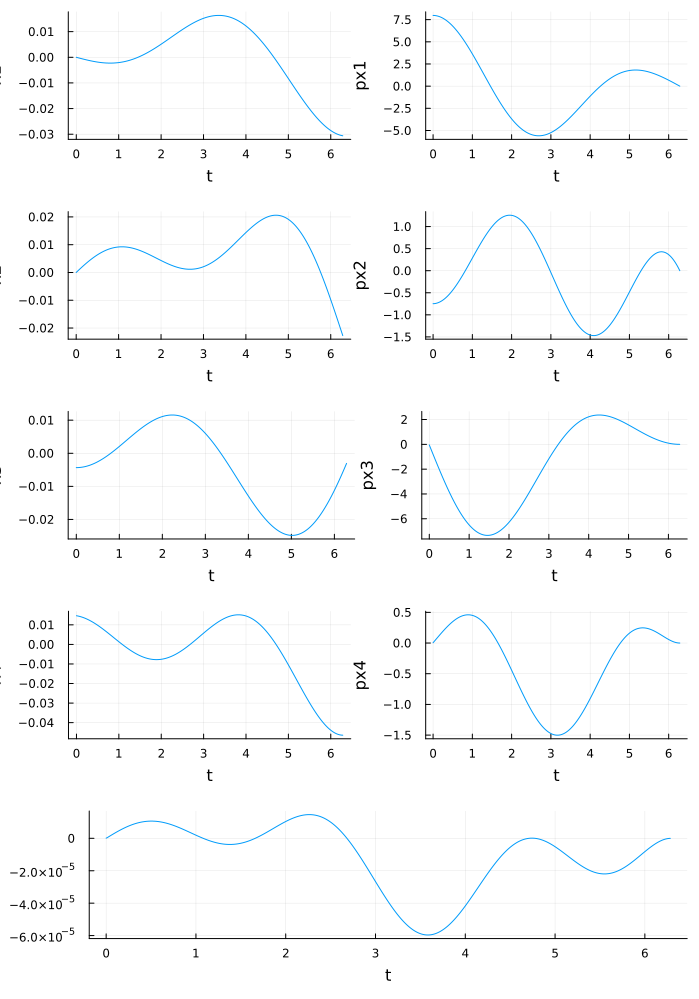

In [6]:
# For plotting results
using Plots

x1_plot = plot(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x1", legend = false)
x2_plot = plot(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "x2", legend = false)
x3_plot = plot(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "x3", legend = false)
x4_plot = plot(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "x4", legend = false)
px1_plot = plot(t, [ p[i][1] for i in 1:nh+1], xlabel = "t", ylabel = "px1", legend = false)
px2_plot = plot(t, [ p[i][2] for i in 1:nh+1], xlabel = "t", ylabel = "px2", legend = false)
px3_plot = plot(t, [ p[i][3] for i in 1:nh+1], xlabel = "t", ylabel = "px3", legend = false)
px4_plot = plot(t, [ p[i][4] for i in 1:nh+1], xlabel = "t", ylabel = "px4", legend = false)


u_plot = plot(t, [ u[i] for i in 1:nh+1], xlabel = "t", ylabel = "u", legend = false)

layout = @layout [a b; c d; e f; g h ;p]
x_plot = plot(x1_plot, px1_plot, x2_plot, px2_plot, x3_plot, px3_plot, x4_plot, px4_plot, u_plot, layout = layout)
x_plot = plot!(x_plot, size = (700, 1000))
display(x_plot)

## 2. Solving with OptimalControl <a id='oc'></a>

In [7]:
using OptimalControl
using NLPModelsIpopt
include("../Problems/OptimalControl/oscillator_OC.jl")
OscillatorOC = double_oscillator_OC();

In [8]:
# Solve the problem
import HSL_jll
sol = OptimalControl.solve(OscillatorOC, grid_size=nh-1, init =(state=[0.0, 0.0, 0.0, 0.0], control=[0.0]),
        linear_solver="ma57",hsllib=HSL_jll.libhsl_path)

Method = (:direct, :adnlp, :ipopt)
This is Ipopt version 3.14.14, running with linear solver ma57.

Number of nonzeros in equality constraint Jacobian...:    14973
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2000

Reallocating memory for MA57: lfact (104238)
Total number of variables............................:     3000
                     variables with only lower bounds:        0
                variables with lower and upper bounds:      500
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2498
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0

CTBase.OptimalControlSolution

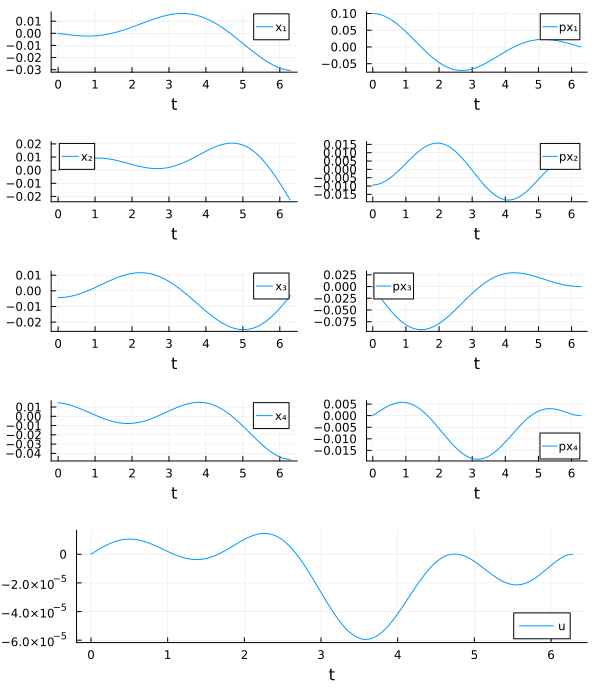

In [9]:
plot(sol)

## 3. Comparison <a id='comp'></a>

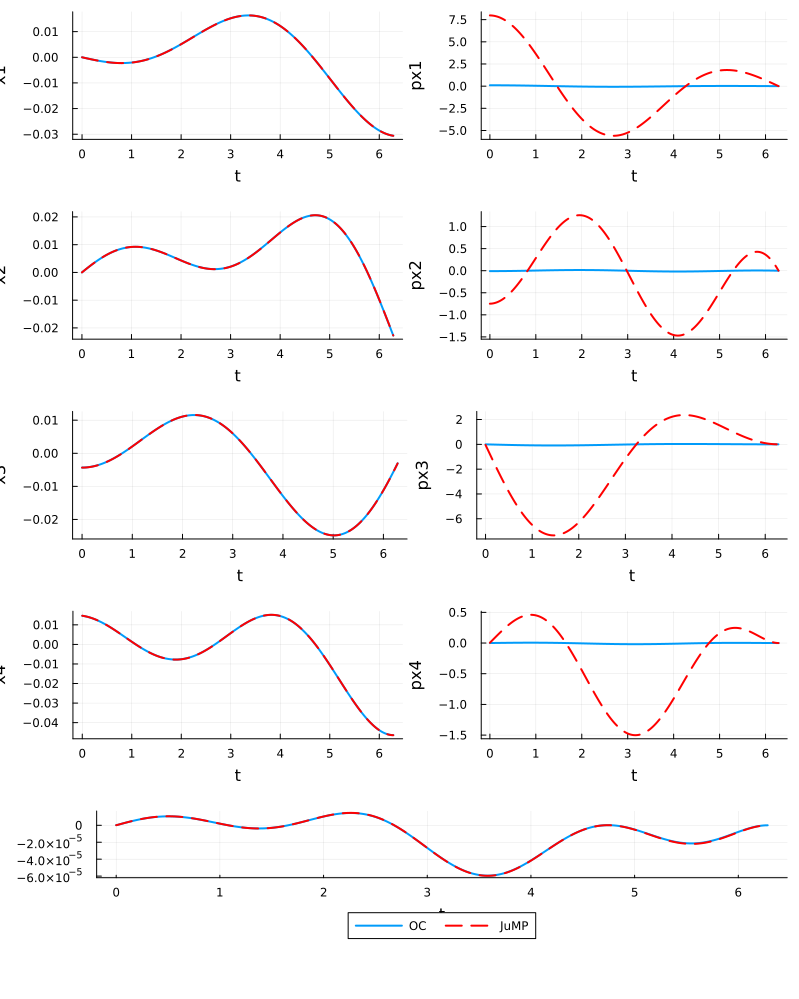

In [10]:
using Plots
p1 = plot(plot(sol)[1],line = 2)
p1 = plot!(t, [ x[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "x1", legend = false,line = 2, color = "red",linestyle=:dash)

p3 = plot(plot(sol)[2],line = 2)
p3 = plot!(t, [ x[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "x2", legend = false,line = 2, color = "red",linestyle=:dash)

p5 = plot(plot(sol)[3],line = 2)
p5 = plot!(t, [ x[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "x3", legend = false,line = 2, color = "red",linestyle=:dash)

p7 = plot(plot(sol)[4],line = 2)
p7 = plot!(t, [ x[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "x4", legend = false,line = 2, color = "red",linestyle=:dash)

p2 = plot(plot(sol)[5],line = 2)
p2 = plot!(t, [ p[i][1] for i in 1:nh+1 ], xlabel = "t", ylabel = "px1", legend = false,line = 2, color = "red",linestyle=:dash)

p4 = plot(plot(sol)[6],line = 2)
p4 = plot!(t, [ p[i][2] for i in 1:nh+1 ], xlabel = "t", ylabel = "px2", legend = false,line = 2, color = "red",linestyle=:dash)

p6 = plot(plot(sol)[7],line = 2)
p6 = plot!(t, [ p[i][3] for i in 1:nh+1 ], xlabel = "t", ylabel = "px3", legend = false,line = 2, color = "red",linestyle=:dash)

p8 = plot(plot(sol)[8],line = 2)
p8 = plot!(t, [ p[i][4] for i in 1:nh+1 ], xlabel = "t", ylabel = "px4", legend = false,line = 2, color = "red",linestyle=:dash)

p9 = plot(plot(sol)[9] , label ="OC",line = 2)
p9 = plot!(t, [u[i] for i in 1:nh+1 ], xlabel = "t", ylabel = "u", legend = false, label = "JuMP",line = 2, color = "red",linestyle=:dash)
p9 = plot!(legend=:outerbottom, legendcolumns=2)

layout = @layout [a b; c d; e f; g h; k]
x_plot = plot(p1, p2, p3, p4, p5, p6, p7 , p8, p9, layout = layout, size = (800, 1000))

display(x_plot)
